In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [ ]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 4s 85ms/step - loss: 0.0320 - val_loss: 0.0103
Epoch 2/200
23/23 [==============================] - 2s 75ms/step - loss: 0.0110 - val_loss: 0.0184
Epoch 3/200
23/23 [==============================] - 3s 112ms/step - loss: 0.0072 - val_loss: 0.0131
Epoch 4/200
23/23 [==============================] - 2s 101ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 5/200
23/23 [==============================] - 2s 69ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 6/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0032 - val_loss: 0.0084
Epoch 7/200
23/23 [==============================] - 2s 75ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 8/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 9/200
23/23 [==============================] - 2s 71ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 10/200
23/23 [==============================] - 2s 91ms/step - loss: 0.0024 - val_loss: 0.00

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 15ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 1630.2880198971277
Testing MAPE: 2.3031279958520128
Testing MAE: 1105.6782368348213


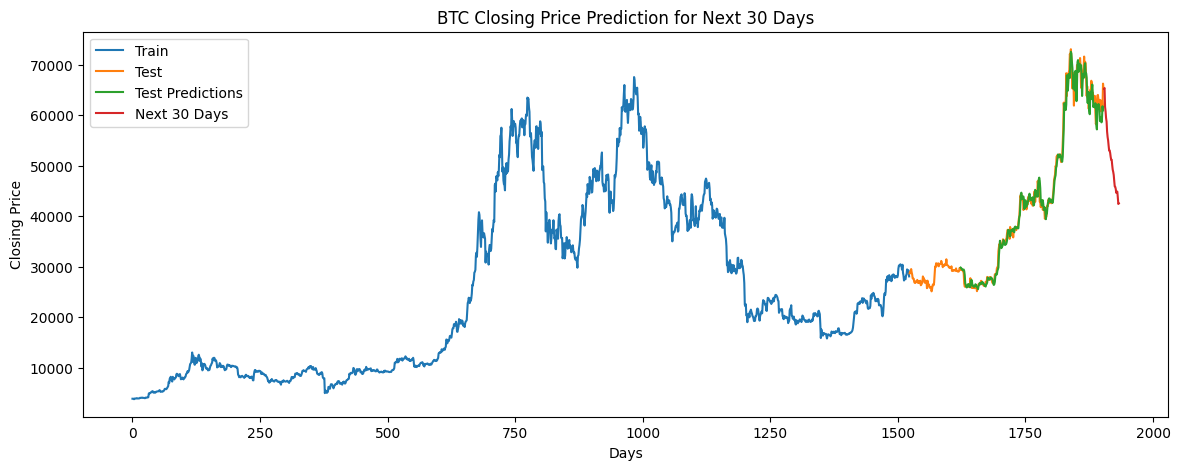

Predicted closing prices for the next 30 days:
[65244.793 65396.508 61669.285 60777.605 59452.78  58753.71  56745.47
 55694.86  55027.145 53965.91  53020.656 53040.254 52551.44  51765.246
 51188.777 51195.73  50127.1   49228.95  48790.055 48163.664 46977.223
 45894.176 45826.2   45362.793 44632.3   44858.65  44892.547 43732.34
 42429.723 42548.457]


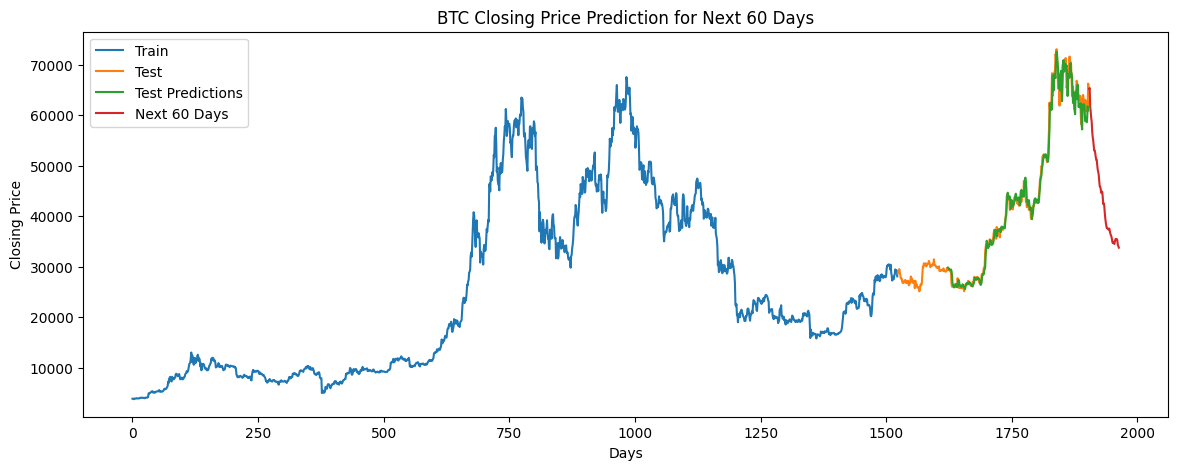

Predicted closing prices for the next 60 days:
[65244.793 65396.508 61669.285 60777.605 59452.78  58753.71  56745.47
 55694.86  55027.145 53965.91  53020.656 53040.254 52551.44  51765.246
 51188.777 51195.73  50127.1   49228.95  48790.055 48163.664 46977.223
 45894.176 45826.2   45362.793 44632.3   44858.65  44892.547 43732.34
 42429.723 42548.457 42077.12  40681.75  39605.004 38815.242 38130.52
 37687.07  37677.832 37499.7   37398.86  37368.51  37573.156 37100.71
 36596.805 36286.582 36068.457 35616.336 34997.66  34681.68  34931.984
 34738.51  34512.24  34924.234 35354.438 35532.297 35470.145 35479.832
 35171.4   34328.164 34102.77  33781.13 ]


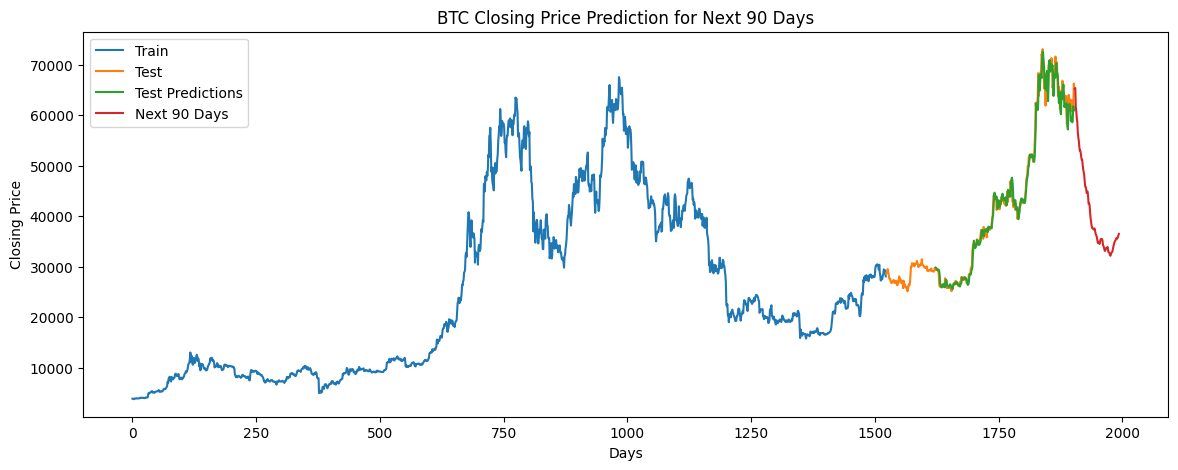

Predicted closing prices for the next 90 days:
[65244.793 65396.508 61669.285 60777.605 59452.78  58753.71  56745.47
 55694.86  55027.145 53965.91  53020.656 53040.254 52551.44  51765.246
 51188.777 51195.73  50127.1   49228.95  48790.055 48163.664 46977.223
 45894.176 45826.2   45362.793 44632.3   44858.65  44892.547 43732.34
 42429.723 42548.457 42077.12  40681.75  39605.004 38815.242 38130.52
 37687.07  37677.832 37499.7   37398.86  37368.51  37573.156 37100.71
 36596.805 36286.582 36068.457 35616.336 34997.66  34681.68  34931.984
 34738.51  34512.24  34924.234 35354.438 35532.297 35470.145 35479.832
 35171.4   34328.164 34102.77  33781.13  33321.285 33125.03  33353.184
 33668.754 33727.676 33673.305 33934.1   33496.023 32895.83  32824.363
 32697.926 32382.738 32167.674 32536.879 32767.33  32870.004 32992.414
 33495.137 33984.6   34392.8   34811.816 35068.586 35161.223 35386.918
 35666.45  35647.023 35580.406 35872.74  36188.61  36516.08 ]


In [ ]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [ ]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 4s 92ms/step - loss: 0.0427 - val_loss: 0.0130
Epoch 2/200
20/20 [==============================] - 2s 108ms/step - loss: 0.0138 - val_loss: 0.0061
Epoch 3/200
20/20 [==============================] - 2s 120ms/step - loss: 0.0094 - val_loss: 0.0062
Epoch 4/200
20/20 [==============================] - 1s 70ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 5/200
20/20 [==============================] - 1s 71ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/200
20/20 [==============================] - 1s 70ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 7/200
20/20 [==============================] - 1s 73ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/200
20/20 [==============================] - 1s 74ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 10/200
20/20 [==============================] - 2s 99ms/step - loss: 0.0032 - val_loss: 0.00

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 13ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 1479.2058023132774
Testing MAPE: 2.4522149455563214
Testing MAE: 986.1569760841294


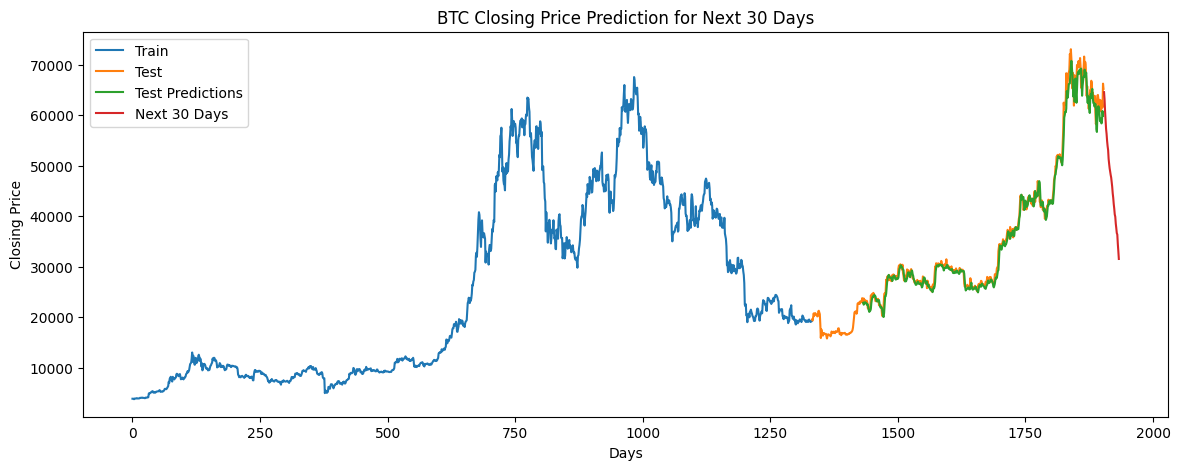

Predicted closing prices for the next 30 days:
[64583.082 63192.438 60814.61  59071.69  57296.73  56307.094 54916.49
 53883.832 53109.145 51357.08  50372.824 49487.227 48860.246 48198.043
 47663.37  46764.31  45822.86  44548.645 43663.31  42432.21  41520.68
 40367.676 39914.816 38552.934 37659.25  36663.46  36376.027 34542.254
 33116.562 31544.625]


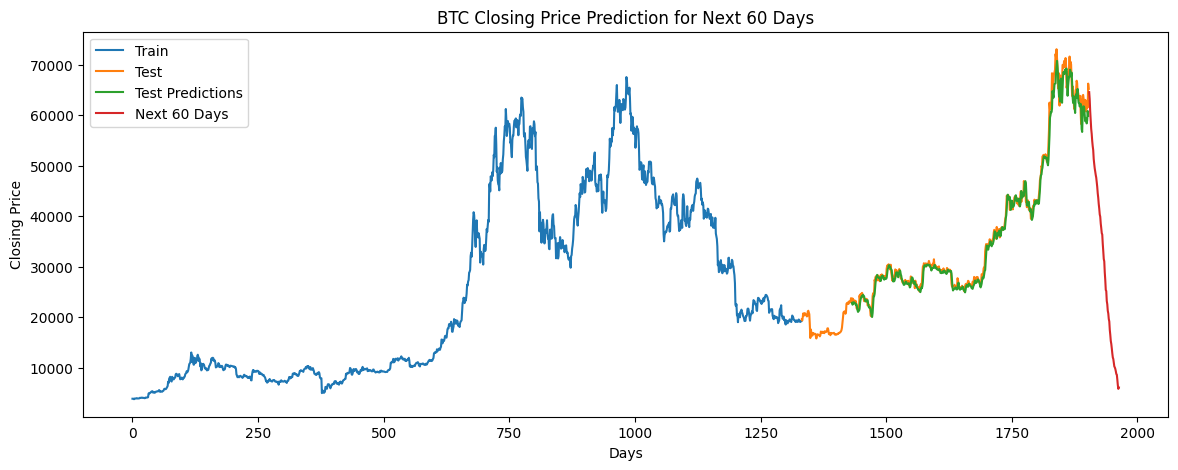

Predicted closing prices for the next 60 days:
[64583.082  63192.438  60814.61   59071.69   57296.73   56307.094
 54916.49   53883.832  53109.145  51357.08   50372.824  49487.227
 48860.246  48198.043  47663.37   46764.31   45822.86   44548.645
 43663.31   42432.21   41520.68   40367.676  39914.816  38552.934
 37659.25   36663.46   36376.027  34542.254  33116.562  31544.625
 31068.65   28886.295  27377.312  25405.156  25177.684  23214.77
 22576.432  21274.033  20753.402  19655.773  19166.195  17499.262
 16498.816  15295.683  14704.064  13819.811  12850.312  12036.592
 11724.627  10988.619  10257.075  10061.588   9760.3955  9293.831
  8757.533   8622.803   7654.7334  6548.808   5808.398   6092.4233]


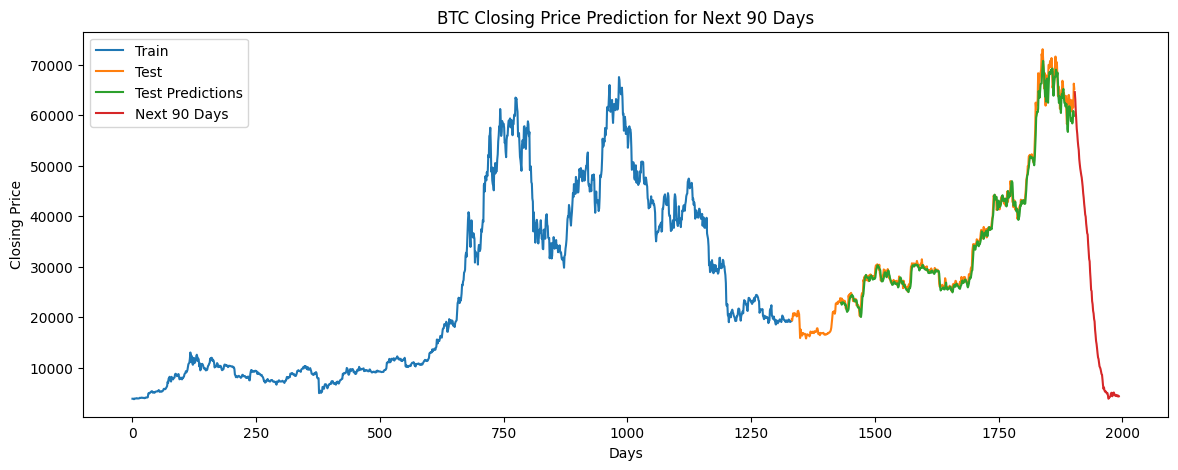

Predicted closing prices for the next 90 days:
[64583.082  63192.438  60814.61   59071.69   57296.73   56307.094
 54916.49   53883.832  53109.145  51357.08   50372.824  49487.227
 48860.246  48198.043  47663.37   46764.31   45822.86   44548.645
 43663.31   42432.21   41520.68   40367.676  39914.816  38552.934
 37659.25   36663.46   36376.027  34542.254  33116.562  31544.625
 31068.65   28886.295  27377.312  25405.156  25177.684  23214.77
 22576.432  21274.033  20753.402  19655.773  19166.195  17499.262
 16498.816  15295.683  14704.064  13819.811  12850.312  12036.592
 11724.627  10988.619  10257.075  10061.588   9760.3955  9293.831
  8757.533   8622.803   7654.7334  6548.808   5808.398   6092.4233
  5453.557   5352.053   5168.6216  5277.1343  5053.5547  4900.1924
  4984.5703  4505.956   3861.6643  3984.6064  4141.7036  4214.8013
  4351.9434  4856.3994  5044.119   4655.866   4350.275   4766.6772
  5053.587   5083.5825  4730.3354  4636.5356  4426.27    4624.558
  4584.79    4401.3594  43

In [ ]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [ ]:
df = pd.read_csv('BTC.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7.661248e+09
1,3/2/2019,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7.578786e+09
2,3/3/2019,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7.253558e+09
3,3/4/2019,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9.029176e+09
4,3/5/2019,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,1.017413e+10
...,...,...,...,...,...,...,...
1899,5/12/2024,60793.503910,61818.156250,60632.601560,61448.394530,61448.394530,1.380046e+10
1900,5/13/2024,61451.218750,63422.660160,60769.839840,62901.449220,62901.449220,2.788918e+10
1901,5/14/2024,62900.773440,63092.125000,61123.765630,61552.789060,61552.789060,2.818627e+10
1902,5/15/2024,61553.988280,66454.453130,61330.410160,66267.492190,66267.492190,3.981517e+10


In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 4s 98ms/step - loss: 0.0569 - val_loss: 0.0379
Epoch 2/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0169 - val_loss: 0.0085
Epoch 3/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 4/200
17/17 [==============================] - 1s 88ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 5/200
17/17 [==============================] - 1s 85ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 6/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 7/200
17/17 [==============================] - 2s 150ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 8/200
17/17 [==============================] - 2s 99ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 9/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0028 - val_loss: 0.0077
Epoch 10/200
17/17 [==============================] - 1s 80ms/step - loss: 0.0029 - val_loss: 0.008

In [ ]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 14ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 2369.6768163855495
Testing MAPE: 7.871556731540753
Testing MAE: 2116.3780786138423


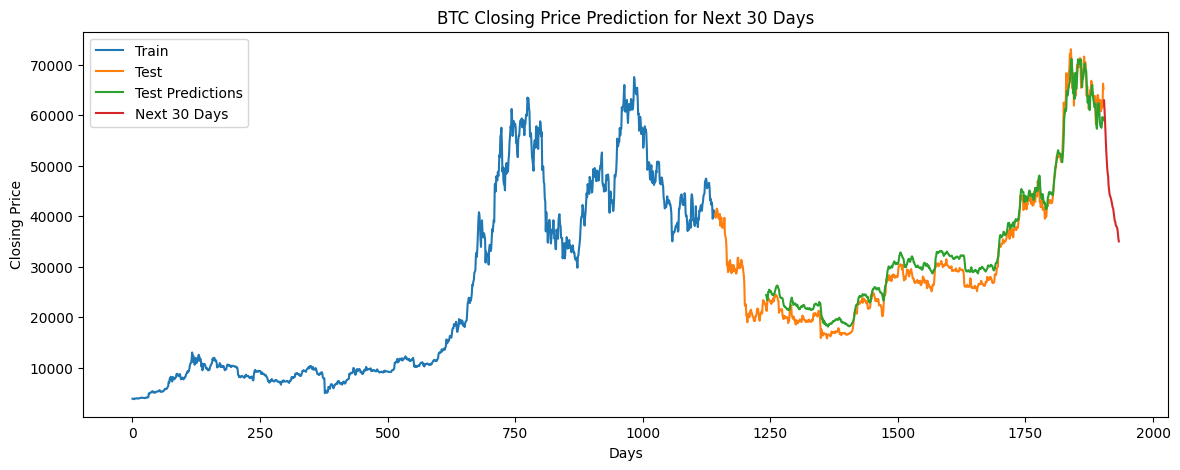

Predicted closing prices for the next 30 days:
[62951.395 61036.45  58778.883 56201.2   53613.723 51723.707 49892.473
 48610.07  47955.066 45981.902 45134.496 44249.312 44006.71  43678.953
 43276.09  42840.8   42244.973 41727.113 41489.816 40652.527 39898.562
 39095.23  38915.863 38234.555 38070.957 37847.023 37600.51  36757.38
 35690.004 35016.133]


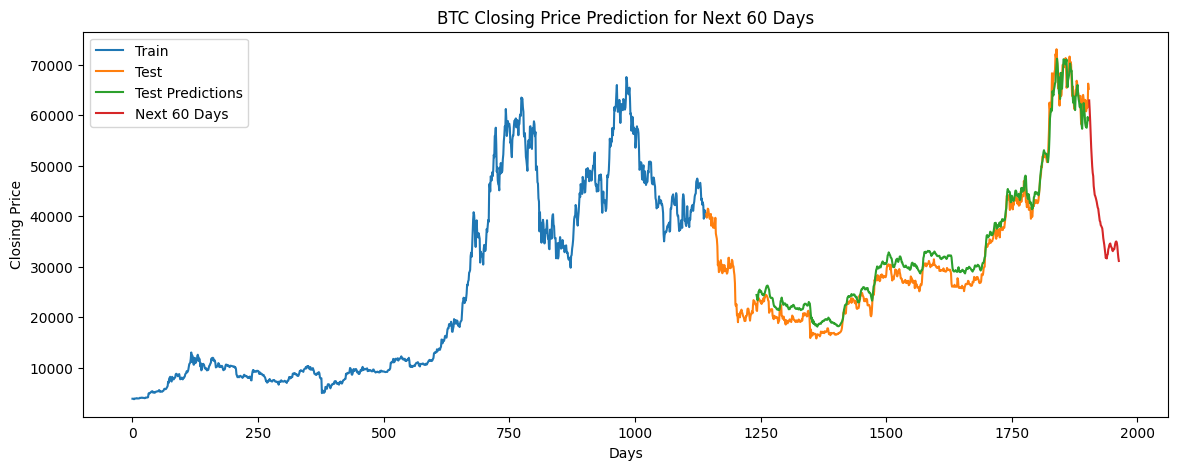

Predicted closing prices for the next 60 days:
[62951.395 61036.45  58778.883 56201.2   53613.723 51723.707 49892.473
 48610.07  47955.066 45981.902 45134.496 44249.312 44006.71  43678.953
 43276.09  42840.8   42244.973 41727.113 41489.816 40652.527 39898.562
 39095.23  38915.863 38234.555 38070.957 37847.023 37600.51  36757.38
 35690.004 35016.133 34371.914 33520.79  32670.967 31721.365 31974.086
 31639.37  32305.93  32473.28  33434.953 33757.918 34272.637 34499.234
 34604.54  34164.246 33884.72  33753.293 33279.246 33088.19  33445.375
 33408.754 33497.645 34092.617 34625.742 34954.266 35011.637 34754.848
 34027.707 32815.336 31810.271 31145.18 ]


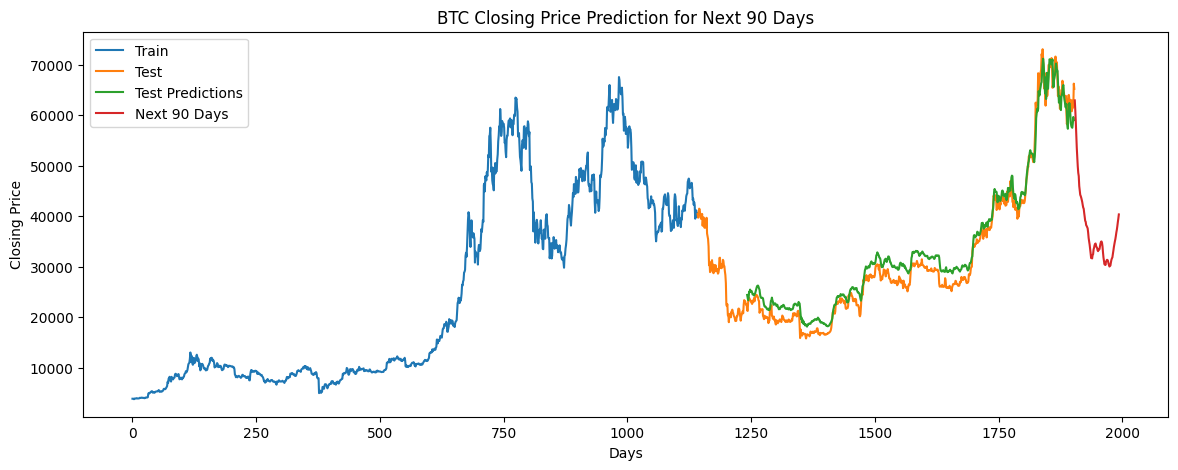

Predicted closing prices for the next 90 days:
[62951.395 61036.45  58778.883 56201.2   53613.723 51723.707 49892.473
 48610.07  47955.066 45981.902 45134.496 44249.312 44006.71  43678.953
 43276.09  42840.8   42244.973 41727.113 41489.816 40652.527 39898.562
 39095.23  38915.863 38234.555 38070.957 37847.023 37600.51  36757.38
 35690.004 35016.133 34371.914 33520.79  32670.967 31721.365 31974.086
 31639.37  32305.93  32473.28  33434.953 33757.918 34272.637 34499.234
 34604.54  34164.246 33884.72  33753.293 33279.246 33088.19  33445.375
 33408.754 33497.645 34092.617 34625.742 34954.266 35011.637 34754.848
 34027.707 32815.336 31810.271 31145.18  30469.578 30585.22  30353.4
 31006.055 31160.46  31368.312 31349.54  31176.668 30681.615 30347.277
 30043.87  30156.178 30240.14  30862.596 31362.352 31655.914 31858.844
 32543.023 33200.355 33907.96  34472.613 35024.188 35485.836 36110.145
 36801.844 37345.188 38053.254 38858.027 39556.875 40363.89 ]


In [ ]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())